In [1]:
import sys, os, argparse
import time
import netCDF4 as nc
from netCDF4 import Dataset
import numpy as np
from numpy import ma 

#Import packages for plotting
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from pylab import imshow,cm

#Import packages for interpolating
from scipy.interpolate import griddata
from scipy.interpolate import LinearNDInterpolator as LNDI

# Import package for parallel computing
from joblib import Parallel, delayed

In [2]:
# Create the parser
parser = argparse.ArgumentParser(description="Process some parameters for clustering.")
# Add required arguments
parser.add_argument("Ncores", type=int, help="Number of CPU's")
parser.add_argument("file_path", type=str, help="Path to the file")
parser.add_argument("parent_directory", type=str, help="Parent directory")
parser.add_argument("results_directory", type=str, help="Results directory")
parser.add_argument("tmin", type=int, help="Minimum time")
parser.add_argument("tmax", type=int, help="Maximum time")
parser.add_argument("lat_resolution", type=float, help="Lat resolution for the IC and the interpolator grid in degrees")
parser.add_argument("lon_resolution", type=float, help="Lon resolution for the IC and the interpolator grid in degrees")
parser.add_argument("dt", type=float, help="Time step size for Runge Kutta")
parser.add_argument("DT", type=float, help="Time step size for Fmap")
# Add optional argument with a default value
parser.add_argument("--freq", type=int, default=10, help="Frequency (default: 10)")
# Parse the arguments
args = parser.parse_args()

Ncores = args.Ncores
file_path = args.file_path
parent_directory = args.parent_directory
results_directory = args.results_directory
tmin = args.tmin
tmax = args.tmax
lat_resolution = args.lat_resolution
lon_resolution = args.lon_resolution
dt = args.dt
DT = args.DT
freq = args.freq
timemod = int(DT/dt) #10


usage: ipykernel_launcher.py [-h] [--freq FREQ]
                             Ncores file_path parent_directory
                             results_directory tmin tmax lat_resolution
                             lon_resolution dt DT
ipykernel_launcher.py: error: argument --freq: invalid int value: '/home/llu/.local/share/jupyter/runtime/kernel-v389ed404a43b40d15288e736059a5d3328c6a384e.json'


SystemExit: 2

/home/llu/venvs/Spectral_Clustering_venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
"""
Ncores = 10
file_path = "/home/llu/Data/OPA-neXtSIM_CREG025_ILBOXE140_2010_ice_latlon_rot_jacob.nc"
parent_directory = "/home/llu/Programs/HPC_Spectral_Clustering/"
results_directory = "/home/llu/Data/"
tmin = 0
tmax = 5
lat_resolution = 0.25
lon_resolution = 0.25
dt = 0.3
DT = 1
freq = 1
timemod = int(DT/dt) #10
"""


In [4]:
#Parameters for random IC
Nt = 500 # Number of random trajectories
seed = 365

Fmap_params = (
    f"tmin{tmin}_"
    f"tmax{tmax}_"
    f"latlonres{lat_resolution}x{lon_resolution}_"
    f"dt{dt}_"
    f"DT{DT}"
)

# Create the results directory if it doesn't exist
try:
    os.makedirs(results_directory, exist_ok=True)
    print(f"Directory '{results_directory}' is ready.")
except Exception as e:
    print(f"An error occurred while creating the directory: {e}")
    sys.exit(1)

Directory '/home/llu/Data/' is ready.


In [5]:
# add utils folder to the TBarrier package
#sys.path.append(T_Barrier_directory+"/subfunctions/utils")
#sys.path.append(T_Barrier_directory+"/subfunctions/integration")
# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/Similarity_matrix_clustering")
sys.path.append(parent_directory+"/subfunctions/Similarity_matrix_construction")
sys.path.append(parent_directory+"/subfunctions/trajectory_advection")
sys.path.append(parent_directory+"/utils")

# Import linear interpolation function for unsteady flow field with irregular grid
from ipynb.fs.defs.Interpolant import interpolant_unsteady
from ipynb.fs.defs.Interpolant import regrid_unsteady
# Import function to compute flow map/particle trajectories
from ipynb.fs.defs.integration_dFdt import integration_dFdt


### Read dataset

In [6]:
print("Reading the input data")
dataset = nc.Dataset(file_path, mode='r')

#from m/s to m/day
siu = dataset.variables['vlon'][tmin:tmax,:,:]
siv = dataset.variables['vlat'][tmin:tmax,:,:]
siu = np.transpose(siu, axes=(1, 2, 0))
siv = np.transpose(siv, axes=(1, 2, 0))
siu = siu[:,:,::freq]
siv = siv[:,:,::freq]
land_mask=siv[:,:,0].mask


# Access coordinates
latitude = dataset.variables['rot_lat'][:]  
longitude = dataset.variables['rot_lon'][:]

# Access specific variables
time_data = dataset.variables['time'][tmin:tmax] 
time_data= np.reshape(time_data, (1,-1))
time_data = time_data[:,::freq]
dataset.close()

Reading the input data


# Interpolate to a regular grid to then generate the interpolator objects.

Note that we interpolate to a 0.1 degree which means that from a grid 493x500 we go to a grid of 761x674 but note that we also have more space in the boundaries

##### Define a regular grid both for the IC and to use to generate the interpolators

In [7]:
print("Interpolating to a regular grid")
# Define the bounds of the grid
lat_min, lat_max = latitude.min(), latitude.max()
lon_min, lon_max = longitude.min(), longitude.max()

latitude_resolution = 0.25
longitude_resolution = 0.25

# Generate the latitude and longitude values
latitudes = np.arange(lat_min, lat_max + latitude_resolution, latitude_resolution)
longitudes = np.arange(lon_min, lon_max + longitude_resolution, longitude_resolution)
# Create a meshgrid
lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)

# Print the shapes of the grids
print(f"Latitude grid shape: {lat_grid.shape}")
print(f"Longitude grid shape: {lon_grid.shape}")

Interpolating to a regular grid
Latitude grid shape: (305, 270)
Longitude grid shape: (305, 270)


#### Interpolate velocities and land_mask into the regular grid

In [8]:
#Land mask: water 0, land 1
mask_interpolator = LNDI(list(zip(latitude.ravel(), longitude.ravel())), land_mask.ravel(),fill_value=1)
mask_interpol=mask_interpolator(lat_grid, lon_grid)

In [9]:
v = siu
def interpolate_frame(t):
    return griddata((latitude.ravel(), longitude.ravel()),v[:, :, t].ravel(),(lat_grid.ravel(), lon_grid.ravel()),method='linear',rescale=False).reshape(lon_grid.shape)
# Parallelize the interpolation over the third dimension
interpolated_data = Parallel(n_jobs=Ncores)(delayed(interpolate_frame)(t) for t in range(v.shape[2]))
# Convert the list of arrays to a single numpy array and transpose
interpolated_siu = np.array(interpolated_data).transpose(1, 2, 0)

In [10]:
v = siv
def interpolate_frame(t):
    return griddata((latitude.ravel(), longitude.ravel()),v[:, :, t].ravel(),(lat_grid.ravel(), lon_grid.ravel()),method='linear',rescale=False).reshape(lon_grid.shape)
# Parallelize the interpolation over the third dimension
interpolated_data = Parallel(n_jobs=Ncores)(delayed(interpolate_frame)(t) for t in range(v.shape[2]))
# Convert the list of arrays to a single numpy array and transpose
interpolated_siv = np.array(interpolated_data).transpose(1, 2, 0)

In [11]:
interpolated_siu = np.ma.masked_array(interpolated_siu, mask=np.repeat(mask_interpol[:, :, np.newaxis], interpolated_siu.shape[2], axis=2))
interpolated_siv = np.ma.masked_array(interpolated_siv, mask=np.repeat(mask_interpol[:, :, np.newaxis], interpolated_siu.shape[2], axis=2))

#At this point the land values are masked but we want to have 0 to be able to advect

#### Set to 0 the land_mask

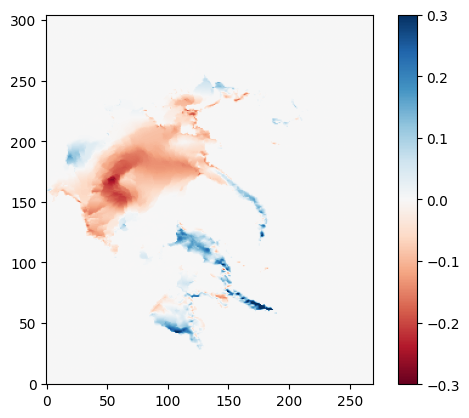

In [12]:
# Set nan values to zero (in case there are any) so that we can apply interpolant. 
# Interpolant does not work if the array contains nan values. 
interpolated_siu[np.isnan(interpolated_siu)] = 0
interpolated_siv[np.isnan(interpolated_siv)] = 0
interpolated_siu = interpolated_siu.filled(0)
interpolated_siv = interpolated_siv.filled(0)

np.save(results_directory+'/siu_regular_grid.npy', interpolated_siu)
np.save(results_directory+'/siv_regular_grid.npy', interpolated_siv)

im = imshow(interpolated_siu[:,:,0],cmap=cm.RdBu,origin="lower",vmin=-0.3,vmax=0.3)#,vmin=-0.000001,vmax=0.000001)
plt.colorbar(im)

In [13]:
# Find the points where the velocity arrays are 0. This means either land or null initial velocity and therefore we don't 
# want to have IC there.

# Initialize the vel_land_mask array with False
vel_land_mask = np.full(lat_grid.shape, False, dtype=bool)
# Compute indices where the velocity is 0 
zero_indices = np.where((interpolated_siu[:,:,0] == 0) & (interpolated_siv[:,:,0] == 0))
# Set the specified indices to True
vel_land_mask[zero_indices] = True
#Generate an interpolator
vel_land_interpolator = LNDI(list(zip(lat_grid.ravel(), lon_grid.ravel())), vel_land_mask.ravel(),fill_value=1)


#### Generate interpolators for advection

In [14]:
print("Generate interpolators for the advection")
# split x0, y0 into 'Ncores' batches for parallel computing
def split3D(a, n):
    k, m = divmod(a.shape[2], n)
    return (a[:,:,i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

siu_batch = list(split3D(interpolated_siu, Ncores)) # list (Nx*Ny)
siv_batch = list(split3D(interpolated_siv, Ncores)) # list (Nx*Ny)


def parallel_interpolant_unsteady(siu_batch, siv_batch):
    # Compute trajectories
    Interpolant = interpolant_unsteady(lon_grid, lat_grid, siu_batch, siv_batch) # method = "linear" leads to linear interpolation

    return Interpolant

start_time = time.time()
results = Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_interpolant_unsteady)(siu_batch[i], siv_batch[i]) for i in range(len(siu_batch)))

# Calculate the elapsed time
elapsed_time = time.time() - start_time
# Print the elapsed time
print(f"Time taken for parallel computation to generate the velocity interpolator objects: {elapsed_time:.2f} seconds")


Interpolant_p = results[0]
for res in results[1:]:
    Interpolant_p = np.append(Interpolant_p, res, axis = 1)

del(results)

# Interpolant is a list containing two interpolation objects:

Interpolant_u = Interpolant_p[0] # Interpolant for U-array
Interpolant_v = Interpolant_p[1] # Interpolant for V-array
del(Interpolant_p)


Generate interpolators for the advection
Time taken for parallel computation to generate the velocity interpolator objects: 0.40 seconds


In [15]:
del siu_batch
del siu
del interpolated_siu
del siv_batch
del siv
del interpolated_siv

### Define initial conditions for advection and keep only sea ice IC (not null velocity, over water)

In [16]:
print("Advecting")
# Generate the latitude and longitude values
IC_lat = np.arange(lat_min, lat_max + lat_resolution, lat_resolution)
IC_lon = np.arange(lon_min, lon_max + lon_resolution, lon_resolution)
# Create a meshgrid
IC_lon_grid, IC_lat_grid = np.meshgrid(IC_lon,IC_lat)
# Print the shapes of the grids

# vectorize initial conditions
lon0 = IC_lon_grid.ravel() # array (Nx*Ny, )
lat0 = IC_lat_grid.ravel() # array (Nx*Ny, )

IC = np.array([lat0, lon0]) # array (2, Nx*Ny)
#Initial conditions over the whole domain

Advecting


In [17]:
# Remove the points where the velocity arrays are 0. This means either land or null initial velocity and therefore we don't 
# want to have IC there.
mask_IC = vel_land_interpolator(np.transpose(IC))
idx_mask_IC = np.where(mask_IC==0)[0]
IC = IC[:,idx_mask_IC]

In [18]:
lonmin = -65
lonmax =-50
latmin = 7
latmax= 10
mask = (IC[0, :] >= latmin) & (IC[0, :] <= latmax) & (IC[1, :] >= lonmin) & (IC[1, :] <= lonmax)
print(np.sum(mask==True))
IC = IC[:, ~mask]

#IC = outflow_detector(IC,7,10,-65,-50)


24


In [19]:
def outflow_detector(IC,latmin,latmax,lonmin,lonmax):
    mask = (IC[0, :] >= latmin) & (IC[0, :] <= latmax) & (IC[1, :] >= lonmin) & (IC[1, :] <= lonmax)
    print("The number of trajectories leaving the domain is: "+str(np.sum(mask==True)))
    return IC[:, ~mask]
#Remove conditions in the baltic
IC = outflow_detector(IC,7,30,-68,-40)
#Remove conditions in saint laurens sea
IC = outflow_detector(IC,-40,-35,-70,-60)


The number of trajectories leaving the domain is: 73
The number of trajectories leaving the domain is: 0


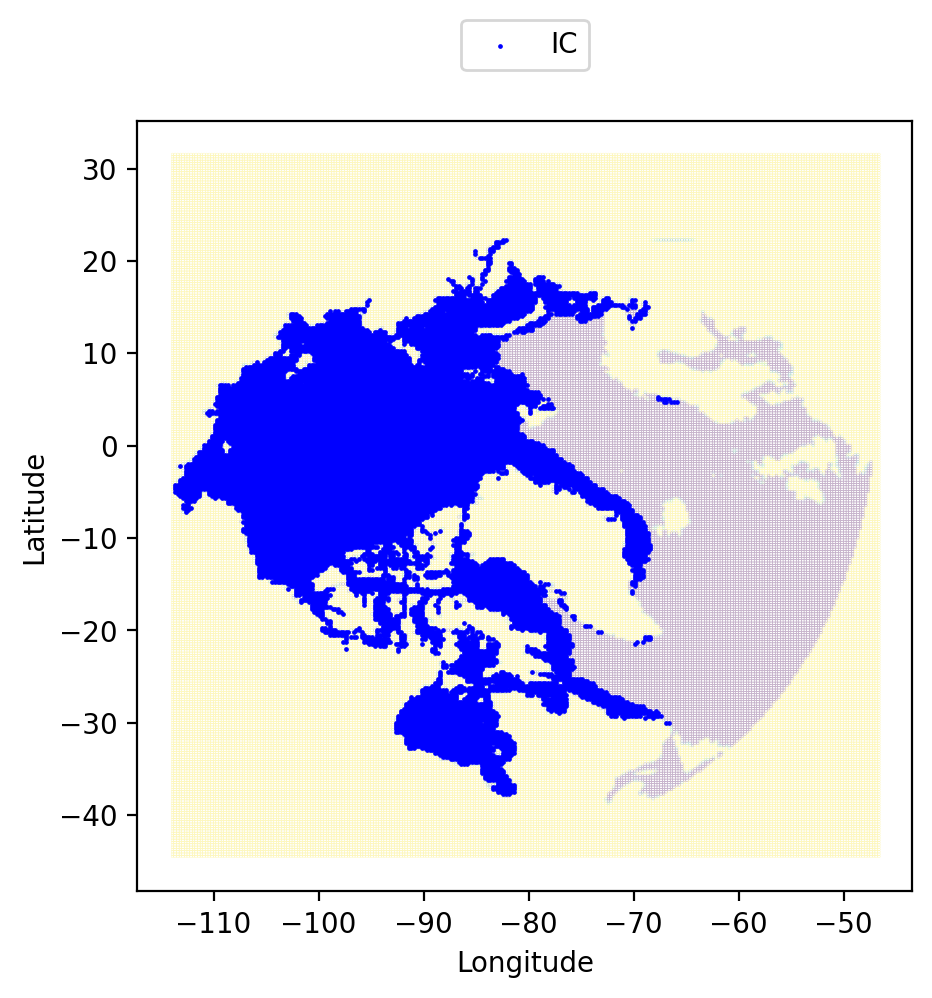

In [20]:
# Plot the trajectories
# Create a colormap from blue to red

fig = plt.figure(figsize=(5, 5), dpi=200)
# Define the colors: white for land and light blue for water
ax = plt.axes()
# Plot the land mask
ax.scatter(lon_grid.ravel(), lat_grid.ravel(), marker=".", s=0.01, c=mask_interpol)
# Plot initial and final positions
ax.scatter(IC[1,:], IC[0, :], label="IC", c="blue", s=0.5)
# Set axis labels and legend
ax.set_xlim(lon_min - 0.05 * (lon_max - lon_min), lon_max + 0.05 * (lon_max - lon_min))
ax.set_ylim(lat_min - 0.05 * (lat_max - lat_min), lat_max + 0.05 * (lat_max - lat_min))
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
# Remove duplicate labels in the legend
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys(), loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.15), fancybox=True)
plt.savefig(results_directory+'/IC.png')

In [21]:
IC.shape

(2, 15647)

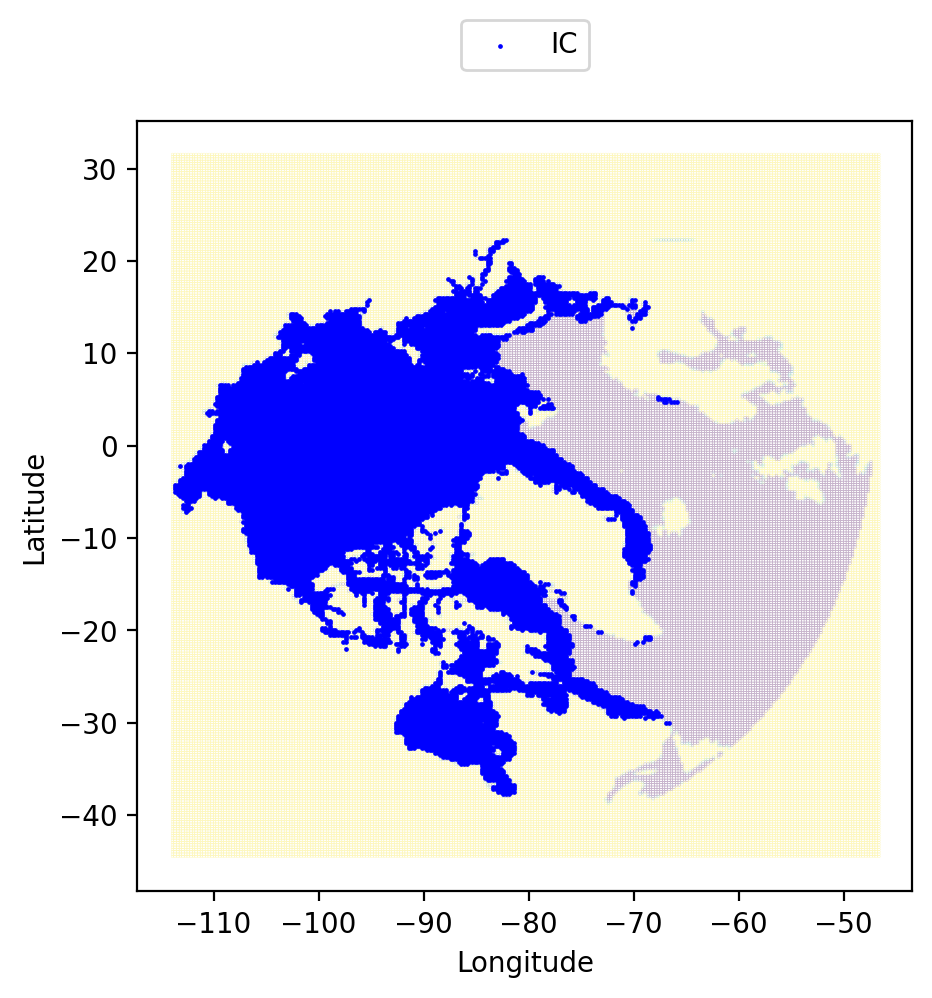

In [22]:
# Plot the trajectories
# Create a colormap from blue to red

fig = plt.figure(figsize=(5, 5), dpi=200)
# Define the colors: white for land and light blue for water
ax = plt.axes()
# Plot the land mask
ax.scatter(lon_grid.ravel(), lat_grid.ravel(), marker=".", s=0.01, c=mask_interpol)
# Plot initial and final positions
ax.scatter(IC[1,:], IC[0, :], label="IC", c="blue", s=0.5)
# Set axis labels and legend
ax.set_xlim(lon_min - 0.05 * (lon_max - lon_min), lon_max + 0.05 * (lon_max - lon_min))
ax.set_ylim(lat_min - 0.05 * (lat_max - lat_min), lat_max + 0.05 * (lat_max - lat_min))
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
# Remove duplicate labels in the legend
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys(), loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.15), fancybox=True)
plt.savefig(results_directory+'/IC.png')

#### Start the velocity advection

In [23]:
print("Advecting trajectories")

# Initial time (in days)
t0 = time_data[0,0]

# Final time (in days)
tN = time_data[0,-1]


# NOTE: For computing the backward trajectories set: tN < t0 and dt < 0.
time_adv = np.arange(t0, tN+dt, dt) # len(time) = N

# Periodic boundary conditions
periodic_x = False
periodic_y = False
periodic_t = False
periodic = [periodic_x, periodic_y, periodic_t]

# Unsteady velocity field
bool_unsteady = True

Advecting trajectories


In [24]:
# split x0, y0 into 'Ncores' batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

x0_batch = list(split(IC[1], Ncores)) # lon
y0_batch = list(split(IC[0], Ncores)) # lat

def parallel_Fmap(x0_batch, y0_batch):
    
    # Initial conditions
    X0 = np.array([x0_batch, y0_batch]) # array (2, Nx*Ny)
    
    # Compute trajectories
    I = integration_dFdt(time_adv, X0, lon_grid, lat_grid, Interpolant_u, Interpolant_v, periodic, bool_unsteady, time_data, verbose = True, linear=False, timemod=timemod) # array (Nt, 2, Nx*Ny)

    return I

results = Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_Fmap)(x0_batch[i], y0_batch[i]) for i in range(len(x0_batch)))
#results is a two dimensional list. First dimension stands for NCores and the result of each core. Second dimension stands for [0] Fmap and [1] dFdt. Then we access an array of
#ntime x latlon x ntrajectories

time_adv_mod = time_adv[::timemod]


Percentage completed:  0.0
Percentage completed:  0.0
Percentage completed:  0.0
Percentage completed:  0.0
Percentage completed:  0.0
Percentage completed:  0.0
Percentage completed:  0.0
Percentage completed:  0.0
Percentage completed:  0.0
Percentage completed:  0.0


In [25]:
Fmap = results[0][0]
DFDt = results[0][1]

for res in results[1:]:
    Fmap = np.append(Fmap, res[0], axis = 2)
    DFDt = np.append(DFDt, res[1], axis = 2)

In [26]:
np.save(results_directory+'/Fmap_matrix.npy', Fmap)
np.save(results_directory+'/advection_time.npy', time_adv_mod)

#### Plot some of the advected trajectories

Ploting the advected trajectories
The number of trajectories with vanishing velocity is 0


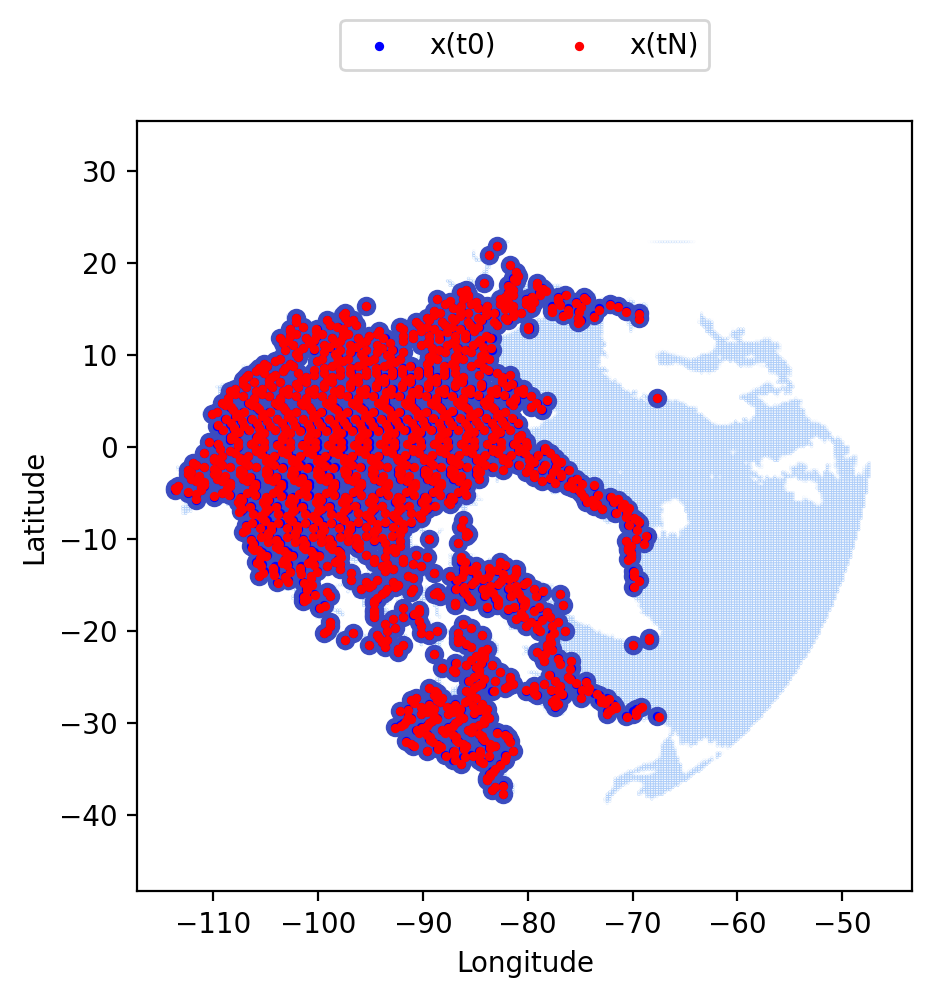

In [27]:
print("Ploting the advected trajectories")
ntraj_filter = 10

DFDt = DFDt[:-1,:,:]
# Trajectories which velocities vanish to zero
nulvel_trajectories_idx = np.unique(np.where((abs(DFDt[:-1,0,:]) < 1e-8) & (abs(DFDt[:-1,1,:]) < 1e-8))[1])
print("The number of trajectories with vanishing velocity is "+str(len(nulvel_trajectories_idx)))

#plot less trajectories than the ones we have
Fmap_filtered = Fmap[:,:,::ntraj_filter]

#Delete trajectories with vanishing velocities
Fmap = np.delete(Fmap,nulvel_trajectories_idx,axis=2)
DFDt = np.delete(DFDt,nulvel_trajectories_idx,axis=2)


# Plot the trajectories
n, _, m = Fmap_filtered.shape
# Create a colormap from blue to red
cmap = plt.get_cmap('coolwarm', n)
fig = plt.figure(figsize=(5, 5), dpi=200)
# Define the colors: white for land and light blue for water
colors = [(0.58, 0.747, 0.972), (1, 1, 1)]  # Light blue and white
custom_cmap = mcolors.LinearSegmentedColormap.from_list("GreyToBlue", colors)
colors = plt.get_cmap(custom_cmap, 2)

ax = plt.axes()
# Plot the land mask
ax.scatter(lon_grid.ravel(), lat_grid.ravel(), marker=".", s=0.1, c=mask_interpol, cmap=colors)
# Plot trajectories with color gradient based on time

for j in range(m):
    # Extract the x and y coordinates for the trajectory
    x = Fmap_filtered[:, 0, j]
    y = Fmap_filtered[:, 1, j]
    
    # Create a color array for the trajectory
    colors = [cmap(i) for i in range(n - 1)]
    
    # Scatter plot for each segment of the trajectory
    ax.scatter(x[:-1], y[:-1], color=colors)

# Plot initial and final positions
ax.scatter(Fmap_filtered[0, 0, :], Fmap_filtered[0, 1, :], label="x(t0)", c="blue", s=5.5)
ax.scatter(Fmap_filtered[-1, 0, :], Fmap_filtered[-1, 1, :], label="x(tN)", c="red", s=5.5)
# Plot vanishing velocity trajectories
#ax.plot(Fmap_filtered[:, 0, nulvel_trajectories_idx_plot], Fmap_filtered[:, 1, nulvel_trajectories_idx_plot], color="yellow", linewidth=1.5, label="Trajectory with vanishing velocity")
# Set axis labels and legend
#ax.set_xlim(lon_min - 0.05 * (lon_max - lon_min), lon_max + 0.05 * (lon_max - lon_min))
#ax.set_ylim(lat_min - 0.05 * (lat_max - lat_min), lat_max + 0.05 * (lat_max - lat_min))
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
# Remove duplicate labels in the legend
handles, labels = ax.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys(), loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.15), fancybox=True)
plt.savefig(results_directory+'/Advected_trajectories_.png')

#### Extra codes

In [28]:
'''
#Non-parallelised advection 
start_time = time.time()
Fmap, DFDt = integration_dFdt(time_adv, IC, lon_grid, lat_grid, Interpolant_u, Interpolant_v, periodic, bool_unsteady, time_data, verbose=True, linear=False, timemod=timemod)
# Calculate the elapsed time
elapsed_time = time.time() - start_time
# Print the elapsed time
print(f"Time taken for advecting trajectories with the RK solver not parallelized: {elapsed_time:.2f} seconds")

time_adv = time_adv[::timemod]
'''


'\n#Non-parallelised advection \nstart_time = time.time()\nFmap, DFDt = integration_dFdt(time_adv, IC, lon_grid, lat_grid, Interpolant_u, Interpolant_v, periodic, bool_unsteady, time_data, verbose=True, linear=False, timemod=timemod)\n# Calculate the elapsed time\nelapsed_time = time.time() - start_time\n# Print the elapsed time\nprint(f"Time taken for advecting trajectories with the RK solver not parallelized: {elapsed_time:.2f} seconds")\n\ntime_adv = time_adv[::timemod]\n'

In [29]:
"""
### Function to generate an array of random tuples
Nt = 10000

print("Defining random initial conditions and filtering masked and water values")
def generate_random_tuples(Nt, xmin, xmax, ymin, ymax, seed=None):
    if seed is not None:
        np.random.seed(seed)  # Set the seed for reproducibility
    x_vals = np.random.uniform(xmin, xmax, Nt)
    y_vals = np.random.uniform(ymin, ymax, Nt)
    tuples_array = np.array(list(zip(x_vals, y_vals)))
    return tuples_array

IC = generate_random_tuples(Nt, lat_min, lat_max, lon_min, lon_max,seed).transpose()
"""

'\n### Function to generate an array of random tuples\nNt = 10000\n\nprint("Defining random initial conditions and filtering masked and water values")\ndef generate_random_tuples(Nt, xmin, xmax, ymin, ymax, seed=None):\n    if seed is not None:\n        np.random.seed(seed)  # Set the seed for reproducibility\n    x_vals = np.random.uniform(xmin, xmax, Nt)\n    y_vals = np.random.uniform(ymin, ymax, Nt)\n    tuples_array = np.array(list(zip(x_vals, y_vals)))\n    return tuples_array\n\nIC = generate_random_tuples(Nt, lat_min, lat_max, lon_min, lon_max,seed).transpose()\n'